# Xgboost model tuning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats.mstats import chisquare, mode
        
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn import metrics, cross_validation
from sklearn.feature_selection import RFE, RFECV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

C:\Users\zhanghui\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\zhanghui\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv("C:/Users/zhanghui/Desktop/Telstra/train_modified_1.csv")
test = pd.read_csv("C:/Users/zhanghui/Desktop/Telstra/test_modified_1.csv")

In [4]:
train.shape , test.shape

((7381, 187), (11171, 186))

In [5]:
train.columns

Index([u'fault_severity', u'id', u'location', u'event_type 10',
       u'event_type 11', u'event_type 13', u'event_type 14', u'event_type 15',
       u'event_type 18', u'event_type 2',
       ...
       u'resource_type 7', u'resource_type 8', u'resource_type 9',
       u'severity_type 1', u'severity_type 2', u'severity_type 3',
       u'severity_type 4', u'severity_type 5', u'location_counts',
       u'feature_count'],
      dtype='object', length=187)

In [6]:
train["fault_severity"].value_counts()

0.0    4784
1.0    1871
2.0     726
Name: fault_severity, dtype: int64

In [7]:
target = "fault_severity"
IDcol = "id"
output_colnames = ["predict_0" , "predict_1" , "predict_2"]

### Class building

The classes below contain some functions designed to make exploration, feature engineering and model building easy. The core runs on Pandas and Sklearn but the functions perform multiple tasks at the same time.

In [3]:
#This class contains the generic classification functions and variable definitions applicable across all models 
class GenericModelClass(object):
    def __init__(self, alg, data_train, data_test, target, predictors=[],cv_folds=5,scoring_metric='accuracy'):
        self.alg = alg                  #an instance of particular model class
        self.data_train = data_train    #training data
        self.data_test = data_test      #testing data
        self.target = target
        self.cv_folds = cv_folds
        self.predictors = predictors
        self.train_predictions = []
        self.train_pred_prob = []
        self.test_predictions = []
        self.test_pred_prob = []
        self.num_target_class = len(data_train[target].unique())

        #define scoring metric:
        self.scoring_metric = scoring_metric

        #grid-search objects:
        self.gridsearch_class = None
        self.gridsearch_result = None

        #Define a Series object to store generic classification model outcomes; 
        self.classification_output=pd.Series(index=['ModelID','Accuracy','CVScore_mean','CVScore_std','AUC',
                                             'ActualScore (manual entry)','CVMethod','ConfusionMatrix','Predictors'])

        #not to be used for all but most
        self.feature_imp = None
    
    #Modify and get predictors for the model:
    def set_predictors(self, predictors):
        self.predictors=predictors

    def get_predictors(self):
        return self.predictors

    def get_test_predictions(self, getprob=False):
        if getprob:
            return self.test_pred_prob
        else:
            return self.test_predictions

    def get_feature_importance(self):
        return self.feature_imp

    def set_scoring_metric(scoring_metric):
        self.scoring_metric = scoring_metric

    #Implement K-Fold cross-validation 
    def KFold_CrossValidation(self, scoring_metric):
        # Generate cross validation folds for the training dataset. 

        error = cross_validation.cross_val_score(self.alg, self.data_train[self.predictors], self.data_train[self.target], 
            cv=self.cv_folds, scoring=scoring_metric, n_jobs=4)
            
        return {'mean_error': np.mean(error),
                'std_error': np.std(error),
                'all_error': error }

    def RecursiveFeatureElimination(self, nfeat=None, step=1, inplace=False):
        
        rfe = RFE(self.alg, n_features_to_select=nfeat, step=step)
        
        rfe.fit(self.data_train[self.predictors], self.data_train[self.target])
        
        ranks = pd.Series(rfe.ranking_, index=self.predictors)
        
        selected = ranks.loc[rfe.support_]

        if inplace:
            self.set_predictors(selected.index.tolist())
        
        return selected

    #Performs similar function as RFE but with CV. It removed features similar to RFE but the importance of the group of features is based on the cross-validation score. The set of features with highest cross validation scores is then chosen. The difference from RFE is that the #features is not an input but selected by algo
    def RecursiveFeatureEliminationCV(self, step=1, inplace=False):
        rfecv = RFECV(self.alg, step=step,cv=self.cv_folds,scoring=self.scoring_metric)
        
        rfecv.fit(self.data_train[self.predictors], self.data_train[self.target])

        min_nfeat = len(self.predictors) - step*(len(rfecv.grid_scores_)-1)  # n - step*(number of iter - 1)
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(min_nfeat, len(self.predictors) + 1,step), rfecv.grid_scores_)
        plt.show(block=False)

        ranks = pd.Series(rfecv.ranking_, index=self.predictors)
        selected = ranks.loc[rfecv.support_]

        if inplace:
            self.set_predictors(selected.index.tolist())
        return ranks

    #Perform Grid-Search with CV:
    def GridSearch(self, param_grid, n_jobs=1,iid=True, cv=None):
        self.gridsearch_class = GridSearchCV(self.alg, param_grid=param_grid, scoring=self.scoring_metric, n_jobs=n_jobs, iid=iid, cv=cv)
        self.gridsearch_class.fit(self.data_train[self.predictors], self.data_train[self.target])
        print ('Grid Search Results:')
        self.gridsearch_result = pd.DataFrame()
        for key in param_grid.keys():
            self.gridsearch_result[key] = [ x[0][key] for x in self.gridsearch_class.grid_scores_]
        self.gridsearch_result['meanCV'] = [x[1] for x in self.gridsearch_class.grid_scores_]
        self.gridsearch_result['stdCV'] = [np.std(x[2]) for x in self.gridsearch_class.grid_scores_]
        print (self.gridsearch_result)
        print ('\nBest Parameters: ', self.gridsearch_class.best_params_)
        print ('\nBest Score: ', self.gridsearch_class.best_score_)
        # return self.gridsearch_class

    # Determine key metrics to analyze the classification model. These are stored in the classification_output series object belonginf to this class.
    def calc_model_characteristics(self, performCV=True):
        self.classification_output['Accuracy'] = metrics.accuracy_score(self.data_train[self.target],self.train_predictions)

        #define scoring metric:
        if self.scoring_metric == 'roc_auc':
            self.classification_output['ScoringMetric'] = metrics.roc_auc_score(self.data_train[self.target],self.train_pred_prob[:,1])        
        elif self.scoring_metric == 'log_loss':
            self.classification_output['ScoringMetric'] = metrics.log_loss(self.data_train[self.target],self.train_pred_prob) 

        if performCV:
            cv_score= self.KFold_CrossValidation(scoring_metric=self.scoring_metric)
        else:
            cv_score={'mean_error': 0.0, 'std_error': 0.0}

        self.classification_output['CVMethod'] = 'KFold - ' + str(self.cv_folds)
        self.classification_output['CVScore_mean'] = cv_score['mean_error']
        self.classification_output['CVScore_std'] = cv_score['std_error']
        if self.num_target_class < 3:
            # print self.data_train[self.target].shape
            # print self.train_pred_prob.shape
            self.classification_output['AUC'] = metrics.roc_auc_score(self.data_train[self.target],self.train_pred_prob[:,1])
        else:
            self.classification_output['AUC'] = np.nan
        self.classification_output['ConfusionMatrix'] = pd.crosstab(self.data_train[self.target], self.train_predictions).to_string()
        self.classification_output['Predictors'] = str(self.predictors)

    # Print the metric determined in the previous function.
    def printReport(self):
        print ("\nModel Report")
        print ("Confusion Matrix:")
        print (pd.crosstab(self.data_train[self.target], self.train_predictions))
        print ('Note: rows - actual; col - predicted')
        # print "\nClassification Report:"
        # print metrics.classification_report(y_true=self.data_train[self.target], y_pred=self.train_predictions)
        print ("Train (Accuracy) : %s" % "{0:.3%}".format(self.classification_output['Accuracy']))
        if self.scoring_metric!='accuracy':
            print ("Train (%s) : %f" % (self.scoring_metric,self.classification_output['ScoringMetric']))
        print ("AUC : %s" % "{0:.3%}".format(self.classification_output['AUC']))
        print ("CV Score (Specified Metric) : Mean - %f | Std - %f" % (self.classification_output['CVScore_mean'],self.classification_output['CVScore_std']))
        
    # create submission file with the absolute prediction
    def submission(self, IDcol, filename="Submission.csv"):
        submission = pd.DataFrame({ x: self.data_test[x] for x in list(IDcol)})
        submission[self.target] = self.test_predictions.astype(int)
        submission.to_csv(filename, index=False)

    # create submission file with the predicted probabilities
    def submission_proba(self, IDcol, proba_colnames,filename="Submission.csv"):
        submission = pd.DataFrame({ x: self.data_test[x] for x in list(IDcol)})
        
        if len(list(proba_colnames))>1:
            for i in range(len(proba_colnames)):
                submission[proba_colnames[i]] = self.test_pred_prob[:,i]
        else: 
            submission[list(proba_colnames)[0]] = self.test_pred_prob[:,1]
        submission.to_csv(filename, index=False)

    #checks whether the ensemble directory exists and creates one if it doesn't
    def create_ensemble_dir(self):
        ensdir = os.path.join(os.getcwd(), 'ensemble')
        if not os.path.isdir(ensdir):
            os.mkdir(ensdir)

XGBoost_Class is designed for multi-classification using xgboost:

In [4]:
#Define the class similar to the overall classification class

class XGBoost_Class(GenericModelClass):
    def __init__(self,data_train, data_test, target, predictors, cv_folds=10,scoring_metric_skl='accuracy', scoring_metric_xgb='error'):
        
        GenericModelClass.__init__(self, alg=XGBClassifier(), data_train=data_train, 
                                   data_test=data_test, target=target, predictors=predictors,cv_folds=cv_folds,scoring_metric=scoring_metric_skl)
        
        #Define default parameters on your own:
        self.default_parameters = { 
                                 'max_depth':3, 'learning_rate':0.1,
                                 'n_estimators':100, 'silent':True,
                                 'objective':"binary:logistic",
                                 'nthread':1, 'gamma':0, 'min_child_weight':1,
                                 'max_delta_step':0, 'subsample':1, 'colsample_bytree':1, 'colsample_bylevel':1,
                                 'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
                                 'base_score':0.5, 'seed':0, 'missing':None
                            }
        self.model_output = pd.Series(self.default_parameters)

        #create DMatrix with no missing:
        self.xgtrain = xgb.DMatrix(self.data_train[self.predictors].values, label=self.data_train[self.target].values)
        self.xgtest = xgb.DMatrix(self.data_test[self.predictors].values)
        self.num_class = 2
        self.n_estimators = 10
        self.eval_metric = 'error'

        self.train_predictions = []
        self.train_pred_prob = []
        self.test_predictions = []
        self.test_pred_prob = []
        self.num_target_class = len(data_train[target].unique())

        #define scoring metric:
        self.scoring_metric_skl = scoring_metric_skl
        self.scoring_metric_xgb = scoring_metric_xgb

        #Define a Series object to store generic classification model outcomes; 
        self.classification_output=pd.Series(index=['ModelID','Accuracy','CVScore_mean','CVScore_std','SpecifiedMetric',
                                             'ActualScore (manual entry)','CVMethod','ConfusionMatrix','Predictors'])

        #feature importance (g_scores)
        self.feature_imp = None
        self.model_output['Feature_Importance'] = "-"

        #Set parameters to default values:
        # self.set_parameters(set_default=True)


    # Set the parameters of the model. 
    # Note: 
    #     > only the parameters to be updated are required to be passed
    #     > if set_default is True, the passed parameters are ignored and default parameters are set which are defined in   scikit learn module
    def set_parameters(self, param=None, set_default=False):
        #Set param to default values if default set
        if set_default:
            param = self.default_parameters

        #Loss function to be used - deviance or exponential
        if 'max_depth' in param:
            self.alg.set_params(max_depth=param['max_depth'])
            self.model_output['max_depth'] = param['max_depth']

        if 'learning_rate' in param:
            self.alg.set_params(learning_rate=param['learning_rate'])
            self.model_output['learning_rate'] = param['learning_rate']

        if 'n_estimators' in param:
            self.alg.set_params(n_estimators=param['n_estimators'])
            self.model_output['n_estimators'] = param['n_estimators']
            self.n_estimators = param['n_estimators']

        if 'silent' in param:
            self.alg.set_params(silent=param['silent'])
            self.model_output['silent'] = param['silent']

        if 'objective' in param:
            self.alg.set_params(objective=param['objective'])
            self.model_output['objective'] = param['objective']

        if 'gamma' in param:
            self.alg.set_params(gamma=param['gamma'])
            self.model_output['gamma'] = param['gamma']

        if 'min_child_weight' in param:
            self.alg.set_params(min_child_weight=param['min_child_weight'])
            self.model_output['min_child_weight'] = param['min_child_weight']

        if 'max_delta_step' in param:
            self.alg.set_params(max_delta_step=param['max_delta_step'])
            self.model_output['max_delta_step'] = param['max_delta_step']

        if 'subsample' in param:
            self.alg.set_params(subsample=param['subsample'])
            self.model_output['subsample'] = param['subsample']

        if 'colsample_bytree' in param:
            self.alg.set_params(colsample_bytree=param['colsample_bytree'])
            self.model_output['colsample_bytree'] = param['colsample_bytree']

        if 'eval_metric' in param:
            self.eval_metric = param['eval_metric']

        if 'nthread' in param:
            self.alg.set_params(nthread=param['nthread'])
            self.model_output['nthread'] = param['nthread']

        if 'colsample_bylevel' in param:
            self.alg.set_params(colsample_bylevel=param['colsample_bylevel'])
            self.model_output['colsample_bylevel'] = param['colsample_bylevel']

        if 'reg_alpha' in param:
            self.alg.set_params(reg_alpha=param['reg_alpha'])
            self.model_output['reg_alpha'] = param['reg_alpha']

        if 'reg_lambda' in param:
            self.alg.set_params(reg_lambda=param['reg_lambda'])
            self.model_output['reg_lambdas'] = param['reg_lambda']

        if 'scale_pos_weight' in param:
            self.alg.set_params(scale_pos_weight=param['scale_pos_weight'])
            self.model_output['scale_pos_weight'] = param['scale_pos_weight']

        if 'base_score' in param:
            self.alg.set_params(base_score=param['base_score'])
            self.model_output['base_score'] = param['base_score']

        if 'seed' in param:
            self.alg.set_params(seed=param['seed'])
            self.model_output['seed'] = param['seed']

        if 'missing' in param:
            self.alg.set_params(missing=param['missing'])
            self.model_output['missing'] = param['missing']
            #update DMatrix with missing:
            self.xgtrain = xgb.DMatrix(self.data_train[self.predictors].values, label=self.data_train[self.target].values, missing=param['missing'])
            self.xgtest = xgb.DMatrix(self.data_test[self.predictors].values, missing=param['missing'])

        if 'num_class' in param:
            self.num_class = param['num_class']

    def modelfit(self, performCV=True, useTrainCV=False, TrainCVFolds=5, early_stopping_rounds=20, printTopN='all'):

        if useTrainCV:
            xgb_param = self.alg.get_xgb_params()
            if self.num_class>2:
                xgb_param['num_class']=self.num_class
            cvresult = xgb.cv(xgb_param,self.xgtrain, num_boost_round=self.alg.get_params()['n_estimators'], nfold=self.cv_folds,
                metrics=self.scoring_metric_xgb, early_stopping_rounds=early_stopping_rounds)
            self.alg.set_params(n_estimators=cvresult.shape[0])

        print (self.alg.get_params())
        obj = self.alg.fit(self.data_train[self.predictors], self.data_train[self.target], eval_metric=self.eval_metric)
        

        #Get train predictions:
        self.train_predictions = self.alg.predict(self.data_train[self.predictors])
        self.train_pred_prob = self.alg.predict_proba(self.data_train[self.predictors])

        #Get test predictions:
        self.test_predictions = self.alg.predict(self.data_test[self.predictors])
        self.test_pred_prob = self.alg.predict_proba(self.data_test[self.predictors])

        self.calc_model_characteristics(performCV)
        self.printReport()

    
    #Export the model into the model file as well as create a submission with model index. This will be used for creating an ensemble.
    def export_model(self, IDcol):
        self.create_ensemble_dir()
        filename = os.path.join(os.getcwd(),'ensemble/xgboost_models.csv')
        comb_series = self.classification_output.append(self.model_output, verify_integrity=True)

        if os.path.exists(filename):
            models = pd.read_csv(filename)
            mID = int(max(models['ModelID'])+1)
        else:
            mID = 1
            models = pd.DataFrame(columns=comb_series.index)
            
        comb_series['ModelID'] = mID
        models = models.append(comb_series, ignore_index=True)
        
        models.to_csv(filename, index=False, float_format="%.5f")
        model_filename = os.path.join(os.getcwd(),'ensemble/xgboost_'+str(mID)+'.csv')
        self.submission(IDcol, model_filename)

### Model tuning

In [9]:
predictors = [x for x in train.columns if x not in [target , IDcol]]

First try get the num_boost_round for 0.1 learning rate

In [10]:
xgb1 = models_classification.XGBoost_Class(train , test , target , predictors , cv_folds=5 , 
                                          scoring_metric_skl="log_loss" , scoring_metric_xgb="mlogloss")

In [11]:
xgb1.set_parameters({
    "learning_rate":0.1 ,
    "n_estimators":500 , 
    "max_depth":10 , 
    "min_child_weight":30 , 
    "gamma":0 , 
    "subsample":0.8 , 
    "colsample_bytree":0.8 ,
    "objective":"multi:softprob",
    "num_class":3 ,
    "eval_metric":["mlogloss"] , 
    "missing":-1 , 
    "nthread":8
})

[0]	train-mlogloss:1.03125+0.000451818	test-mlogloss:1.03292+0.00152209
[1]	train-mlogloss:0.973459+0.00132043	test-mlogloss:0.976773+0.0025301
[2]	train-mlogloss:0.924802+0.00147518	test-mlogloss:0.929772+0.00313464
[3]	train-mlogloss:0.881974+0.00149825	test-mlogloss:0.888215+0.00365499
[4]	train-mlogloss:0.845148+0.00221368	test-mlogloss:0.852764+0.00380317
[5]	train-mlogloss:0.811467+0.00258229	test-mlogloss:0.820504+0.00372743
[6]	train-mlogloss:0.781945+0.00316279	test-mlogloss:0.79242+0.00450539
[7]	train-mlogloss:0.756682+0.00385287	test-mlogloss:0.768831+0.00419456
[8]	train-mlogloss:0.733568+0.00443476	test-mlogloss:0.74708+0.00461934
[9]	train-mlogloss:0.712174+0.00403812	test-mlogloss:0.726951+0.00512381
[10]	train-mlogloss:0.69352+0.0036112	test-mlogloss:0.709408+0.00552307
[11]	train-mlogloss:0.676423+0.0035459	test-mlogloss:0.693623+0.00589351
[12]	train-mlogloss:0.661137+0.00341619	test-mlogloss:0.679718+0.0059201
[13]	train-mlogloss:0.647659+0.00371009	test-mlogloss:0.

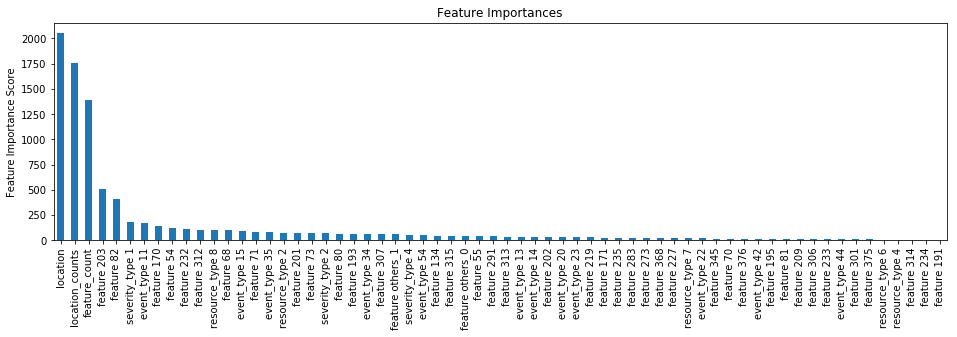


Model Report
Confusion Matrix:
col_0            0.0   1.0  2.0
fault_severity                 
0.0             4326   319  139
1.0              561  1218   92
2.0              109    60  557
Note: rows - actual; col - predicted
Train (Accuracy) : 82.658%
Train (log_loss) : 0.425501
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [12]:
xgb1.modelfit(useTrainCV=True , performCV=False)

Second round:

In [13]:
xgb2 = models_classification.XGBoost_Class(train , test , target , predictors , cv_folds=5 , 
                                          scoring_metric_skl="log_loss" , scoring_metric_xgb="mlogloss")

Initial parameters:

In [15]:
xgb2.set_parameters({
    "learning_rate":0.1,
    "n_estimators":96 , 
    "max_depth":10 , 
    "min_child_weight":30 , 
    "gamma":0,
    "subsample":0.8 , 
    "colsample_bytree":0.8 , 
    "objective":"multi:softprob",
    "num_class":3,
    "eval_metric":["nlogloss"],
    "missing":-1 , 
    "nthread":8
})

In [16]:
param_test1 = {
    "max_depth":range(8 , 17 , 2) , 
    "min_child_weight":range(10 , 51 , 10)
}

Gridsearch for max_depth and min_child_weight:

In [17]:
xgb2.GridSearch(param_test1 , n_jobs=8 , iid=False , cv=5)

/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


Grid Search Results:
    max_depth  min_child_weight    meanCV     stdCV
0           8                10 -0.512025  0.012406
1           8                20 -0.525961  0.013494
2           8                30 -0.532522  0.013130
3           8                40 -0.539531  0.013680
4           8                50 -0.548119  0.014265
5          10                10 -0.510827  0.012829
6          10                20 -0.525301  0.013944
7          10                30 -0.530660  0.013507
8          10                40 -0.537472  0.014186
9          10                50 -0.547017  0.014123
10         12                10 -0.511896  0.013434
11         12                20 -0.525775  0.015117
12         12                30 -0.530108  0.014881
13         12                40 -0.536800  0.014505
14         12                50 -0.546834  0.014699
15         14                10 -0.513530  0.014247
16         14                20 -0.525569  0.014871
17         14                30 -0.529816  

In [18]:
xgb2b = models_classification.XGBoost_Class(train , test , target , predictors , cv_folds=5 , 
                                           scoring_metric_skl="log_loss" , scoring_metric_xgb="mlogloss")

In [19]:
xgb2b.set_parameters({
    "learning_rate":0.1 , 
    "n_estimators":96 , 
    "max_depth":10 , 
    "min_child_weight": 10 , 
    "gamma":0 , 
    "subsample":0.8 , 
    "colsample_bytree":0.8,
    "objective":"multi:softprob",
    "num_class":3 , 
    "eval_metric":["mlogloss"] , 
    "missing":-1 , 
    "nthread":8
})
param_test2 = {
    "min_child_weight":range(4 , 11)
}

Gridsearch for min_child_weight:

In [20]:
xgb2b.GridSearch(param_test2 , n_jobs=8 , iid = False , cv=5)

/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


Grid Search Results:
   min_child_weight    meanCV     stdCV
0                 4 -0.506169  0.015199
1                 5 -0.508023  0.017488
2                 6 -0.507015  0.014337
3                 7 -0.508633  0.013757
4                 8 -0.510571  0.013248
5                 9 -0.512233  0.012554
6                10 -0.510827  0.012829

Best Parameters:  {'min_child_weight': 4}

Best Score:  -0.506168862982


In [21]:
xgb2c = models_classification.XGBoost_Class(train , test , target , predictors , cv_folds=5 , 
                                           scoring_metric_skl="log_loss" , scoring_metric_xgb="mlogloss")
xgb2c.set_parameters({
    "learning_rate":0.1 , 
    "n_estimators": 96 , 
    "max_depth":10 , 
    "min_child_weight":4 , 
    "gamma":0 , 
    "subsample":0.8 , 
    "colsample_bytree":0.8 , 
    "objective":"multi:softprob" , 
    "num_class":3 , 
    "eval_metric":["mlogloss"] , 
    "missing":-1 , 
    "ntrhead":8
})

In [22]:
param_test3 = {
    "min_child_weight":range(1 , 4)
}

Gridsearch for min_child_weight:

In [23]:
xgb2c.GridSearch(param_test3 , n_jobs=8 , iid=False , cv=5)

/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/zhanghsiungwei/anaconda/envs/tensor/lib/python2.7/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


Grid Search Results:
   min_child_weight    meanCV     stdCV
0                 1 -0.504943  0.019168
1                 2 -0.504453  0.018142
2                 3 -0.506007  0.018020

Best Parameters:  {'min_child_weight': 2}

Best Score:  -0.50445254773


Final version of parameters:

In [25]:
xgb2c.set_parameters({
    "learninng_rate":0.1 , 
    "n_estimators":300 , 
    "max_depth":10, 
    "min_child_weight":2 ,
    "subsample":0.8 , 
    "colsample_bytree":0.8 , 
    "objective":"multi:softprob" , 
    "num_class":3 , 
    "eval_metric":["mlogloss"] , 
    "missing":-1 , 
    "nthread":8
})

[0]	train-mlogloss:1.02155+0.00113384	test-mlogloss:1.02921+0.00147061
[1]	train-mlogloss:0.955034+0.0017382	test-mlogloss:0.969579+0.00188364
[2]	train-mlogloss:0.899115+0.00246524	test-mlogloss:0.920394+0.00274735
[3]	train-mlogloss:0.849561+0.00248509	test-mlogloss:0.876937+0.0033016
[4]	train-mlogloss:0.80594+0.00303735	test-mlogloss:0.839188+0.00321987
[5]	train-mlogloss:0.765276+0.00284177	test-mlogloss:0.804781+0.00325307
[6]	train-mlogloss:0.729564+0.003408	test-mlogloss:0.774823+0.00387508
[7]	train-mlogloss:0.698761+0.00453744	test-mlogloss:0.749633+0.00341577
[8]	train-mlogloss:0.670647+0.0055263	test-mlogloss:0.726792+0.00426561
[9]	train-mlogloss:0.643665+0.00496368	test-mlogloss:0.705255+0.00510115
[10]	train-mlogloss:0.620002+0.00396576	test-mlogloss:0.686583+0.00556108
[11]	train-mlogloss:0.598218+0.00368434	test-mlogloss:0.669512+0.00593798
[12]	train-mlogloss:0.578038+0.00380791	test-mlogloss:0.654166+0.00604066
[13]	train-mlogloss:0.560473+0.004847	test-mlogloss:0.64

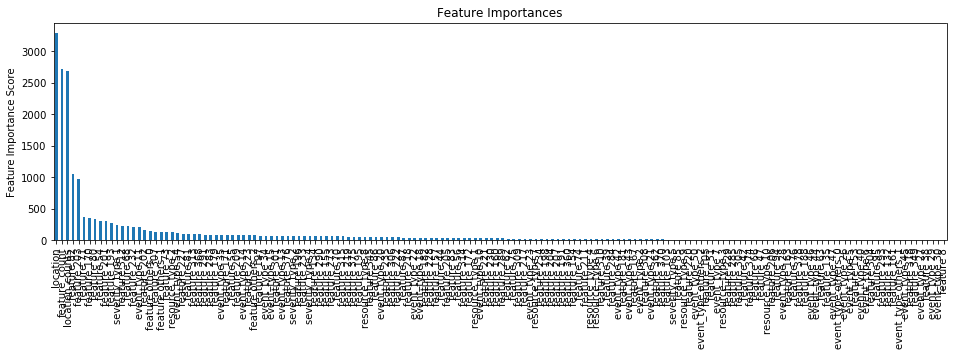


Model Report
Confusion Matrix:
col_0            0.0   1.0  2.0
fault_severity                 
0.0             4544   191   49
1.0              370  1468   33
2.0               44    24  658
Note: rows - actual; col - predicted
Train (Accuracy) : 90.367%
Train (log_loss) : 0.300871
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [26]:
xgb2c.modelfit(useTrainCV=True , performCV=False)

In [27]:
xgb2c.submission_proba(IDcol=[IDcol] , proba_colnames=output_colnames , filename="C:/Users/zhanghui/Desktop/Telstra/xgb2c.csv")

#### The submission ------- private score: 0.50624. Public score 0.50949